In [6]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

In [7]:
if not os.path.exists('facial_keypoints.npz'):
  !wget -O facial_keypoints.npz "https://www.dropbox.com/scl/fi/27qggijmythfjg04s24xq/facial_keypoints.npz?rlkey=h91gwodhrfuz8hrc7ux9qnq7s&dl=1"

In [8]:
data = np.load('facial_keypoints.npz')
images = data['images']
keypoints = data['keypoints']

Images - Shape: (7049, 1, 96, 96), Dtype: int64, Min: 0, Max: 255
Keypoints - Shape: (7049, 30), Dtype: float32, Min: 0.6865919828414917, Max: 95.9356460571289


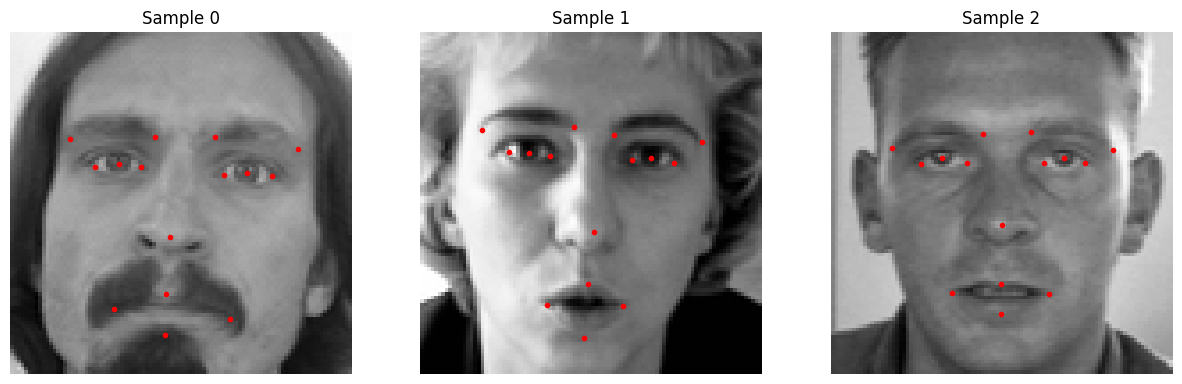

In [13]:
# Print details
print(f"Images - Shape: {images.shape}, Dtype: {images.dtype}, Min: {np.nanmin(images)}, Max: {np.nanmax(images)}")
print(f"Keypoints - Shape: {keypoints.shape}, Dtype: {keypoints.dtype}, Min: {np.nanmin(keypoints)}, Max: {np.nanmax(keypoints)}")

# Show some images with keypoints
num_samples_to_show = 3
fig, axes = plt.subplots(1, num_samples_to_show, figsize=(15, 5))

for i in range(num_samples_to_show):
    img = images[i].squeeze()  # Shape: (height, width)
    kp = keypoints[i].reshape(-1, 2)  # Shape: (num_keypoints, 2)
    
    # Plot image
    axes[i].imshow(img, cmap='gray')
    
    # Plot keypoints
    axes[i].plot(kp[:, 0], kp[:, 1], 'r.')  # Red dots for keypoints
    axes[i].set_title(f"Sample {i}")
    axes[i].axis("off")

plt.show()

In [16]:
images_tensor = torch.tensor(images, dtype=torch.float32)  # Convert to tensor
keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32)  # Convert keypoints

images_tensor /= 255 # Normalize values between 0 and 1

In [17]:
# 1. Divide data into train and test splits

import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(images_tensor, keypoints_tensor, random_state=0, train_size = .75)

In [18]:
batch = 32

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False)


In [22]:
# 2. Create a neural network for this dataset. 
cnn_model = torch.nn.Sequential(

    # Conv 1
    torch.nn.Conv2d(1, 96, kernel_size=3, padding=1),    
    torch.nn.ReLU(),

    # Conv 2
    torch.nn.Conv2d(96, 96, kernel_size=3, padding=1),
    torch.nn.ReLU(),

    # Pool 1
    torch.nn.MaxPool2d(kernel_size=2, stride=2),

    # Conv 3
    torch.nn.Conv2d(96, 48, kernel_size=3, padding=1),
    torch.nn.ReLU(),

    # Conv 4
    torch.nn.Conv2d(48, 48, kernel_size=3, padding=1),
    torch.nn.ReLU(),

    # Pool 2
    torch.nn.MaxPool2d(kernel_size=2, stride=2),

    # Flatten
    torch.nn.Linear(48 * 24 * 24, 512),
    torch.nn.Linear(512, 30)

)

# Create a cross-entropy loss function and a stochastic gradient descent (SGD) optimizer
loss_fn = torch.nn.MSELoss()
lr = 1e-4
opt = torch.optim.Adam(cnn_model.parameters(), lr=lr)

In [29]:
# Check if CUDA (GPU) is available and move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

epochs = 100

for epoch in range(epochs):
    total_loss = 0
    cnn_model.train()  # Set the model to training mode

    for batch_X, batch_y in train_dataloader:
        # Move batch data to the correct device (GPU or CPU)
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Make sure the input has the correct shape (batch_size, 1, height, width)
        if len(batch_X.shape) == 3:
            batch_X = batch_X.unsqueeze(1)  # Add channel dimension (1)

        opt.zero_grad()  # Zero out gradients

        # Forward pass
        z = cnn_model(batch_X)  

        # Compute loss
        loss = loss_fn(z, batch_y)  

        # Backpropagation
        loss.backward()  

        # Apply gradients
        opt.step()  

        # Accumulate loss
        total_loss += loss.item()

    # Print out the loss for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_dataloader):.4f}")


RuntimeError: Given groups=1, weight of size [48, 48, 3, 3], expected input[32, 96, 48, 48] to have 48 channels, but got 96 channels instead

In [28]:
# c. Function to train model

def trainModel(model, train_loader, opt, loss_fn):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_model.to(device)
    model.train()
    epochs = 100
    for epoch in range(epochs):
        total_loss = 0

        for batch_X, batch_y in train_loader:
            opt.zero_grad()  # 1. zero out gradients

            z = model(batch_X)  # 2. Forward pass
            loss = loss_fn(z, batch_y)  # 3. Compute loss

            loss.backward()  # 4. Backpropagation
            opt.step()  # 5. Apply gradients

            total_loss += loss.item()

        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, ")
        
trainModel(cnn_model, train_dataloader, opt, loss_fn)


RuntimeError: Given groups=1, weight of size [48, 48, 3, 3], expected input[32, 96, 48, 48] to have 48 channels, but got 96 channels instead